In [212]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

### Путь к файлам

In [213]:
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'
TEST_DATASET_EXT_PATH = 'schelakov_predict.csv'

### Функции

In [214]:
# уменьшение требуемого размера памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# преобразование категориального признака в булевый
def to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

# замена значений в столбцах при выбросах если больше или меньше
def if_more(column, x):
    df.loc[df[column] > x, column] = df[column].median()
    
def if_less(column, x):
    df.loc[df[column] < 15, column] = df[column].median()

### Изучение и подготовка данных

In [215]:
df = pd.read_csv(TRAIN_DATASET)
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [216]:
df.info()
# есть пропуски в LifeSquare и Healthcare_1
# 3 категориальных признака

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [217]:
df.describe()
# Rooms - есть объекты с 0 количеством комнат
# Square, LifeSquare и KitchenSquare - очень странные минимальные значения площадей

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


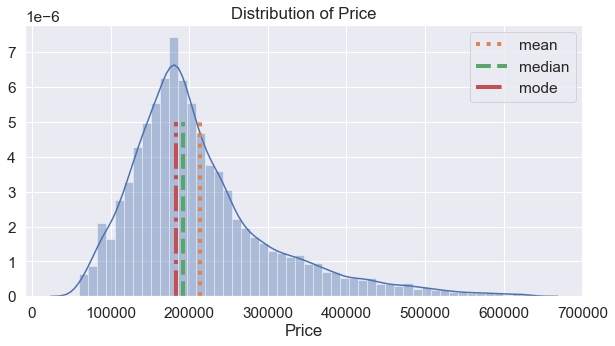

In [218]:
# распределение целевой переменной

target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

plt.figure(figsize = (10, 5))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

# распределение выглядит как нормальное, выбросов не вижу. Среднее и медиана довольно близко друг к другу.

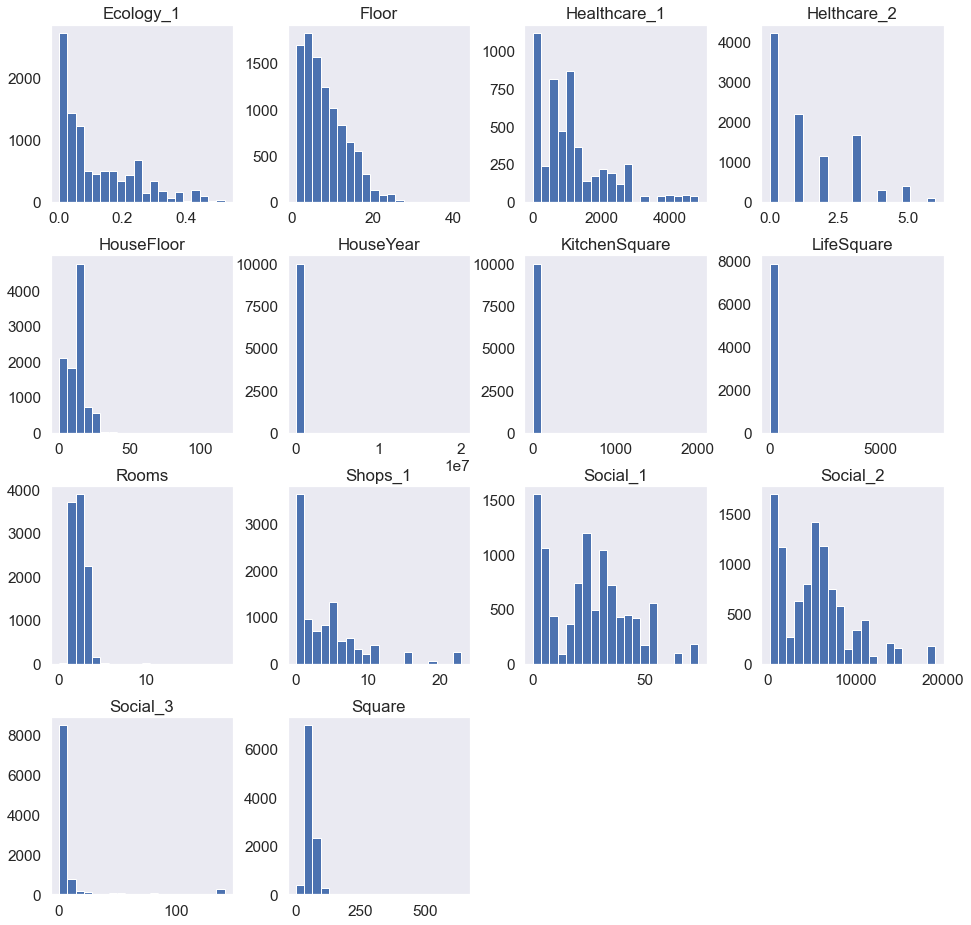

In [219]:
# посмотрим на количественные признаки
df_num_features = df.select_dtypes(include=['int8', 'int16', 'int32', 'float32'])
df_num_features.drop(['Price', 'Id', 'DistrictId'], axis=1, inplace=True)

df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [220]:
# посмотрим на категориальные
cat_features = df.select_dtypes(include='category').columns

for column in cat_features:
    print(f'{df[column].value_counts()}')

#они принимают всего два значения, их можно преобразовать в бинарные признаки

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [221]:
def prepare_data(df):
    # Healthcare_1 пропущено почти 50% данных. Удаляю из признаков
    df.drop(['Healthcare_1'], axis=1, inplace=True)

    # Я смотрел ящик с усами для LifeSquare, все что больше 80 можно считать выбросом. Заменю их на медианное значение. Также обработаю и nan
    if_more('LifeSquare', 80)
    median = df['LifeSquare'].median()
    df['LifeSquare'].fillna(median, inplace=True)
    
    # Square меньше 15 и больше 100 тоже выбросыю Заменб их медианами
    if_more('Square', 100)
    if_less('Square', 15)

    # KitchenSquare больше 25 тоже выбросы Заменб их медианами
    if_more('KitchenSquare', 25)

    # У нас есть объекты для которых площадь меньше жилой площади. Такого быть не может, поэтому жилую площадь делаеем = обзая плозадь - площадь кухни
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df['Square'] - df['KitchenSquare']

    # Преобразую категориальные признаки в бинарные
    to_bool(cat_features, df)

    # HouseYear содержит выбросы в максимуме, заменю их на медиану
    mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year
    return df

In [222]:
prepare_data(df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,52.513309,32.781261,10.0,4,10.0,2014.0,0.075424,False,False,11,3097,0,0,0,False,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966.0,0.118537,False,False,30,6207,1,1,0,False,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988.0,0.025609,False,False,33,5261,0,3,1,False,282078.718750
3,2352,1,1.0,40.409908,32.781261,1.0,10,22.0,1977.0,0.007122,False,False,1,264,0,0,1,False,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972.0,0.282798,False,False,33,8667,2,0,6,False,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981.0,0.300323,False,False,52,10311,6,1,9,False,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977.0,0.072158,False,False,2,629,1,0,0,True,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958.0,0.460556,False,False,20,4386,14,1,5,False,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969.0,0.194489,False,False,47,8004,3,3,5,False,171842.406250


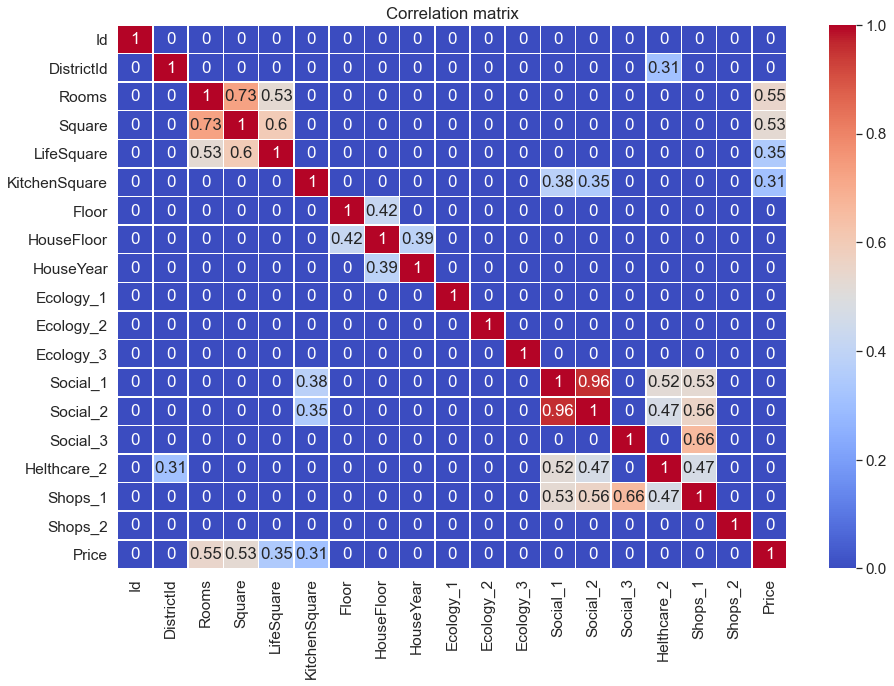

In [223]:
# матрица корреляций

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# видно, что таргет имеет прямую связь с количеством комнат и площадями.
# Так же они между собой связаны, значит можно применить на них понижение размерности

### Стандартизация признаков

In [224]:
from sklearn.preprocessing import StandardScaler

In [225]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [226]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

target_name = 'Price'

In [227]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['int8', 'int16', 'int32', 'float32']).columns.tolist()

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [228]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [229]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,11809,-0.536895,1.321667,-0.127271,-0.067526,1.105433,-0.863728,-0.385115,2014.0,-0.364931,False,False,-0.780698,-0.562861,-0.337347,-0.883480,-0.880402,False,305018.875000
1,3013,-0.651613,-1.060788,-0.938401,-0.863613,0.592769,-0.291306,-0.680290,1966.0,-0.002690,False,False,0.303050,0.213359,-0.295384,-0.213923,-0.880402,False,177734.546875
2,8215,-1.133425,1.321667,1.524884,1.165751,1.105433,-1.245343,0.647998,1988.0,-0.783473,False,False,0.474169,-0.022752,-0.337347,1.125190,-0.672333,False,282078.718750
3,2352,-1.133425,-1.060788,-0.901469,-0.067526,-1.201558,0.281117,1.385936,1977.0,-0.938799,False,False,-1.351093,-1.269944,-0.337347,-0.883480,-0.672333,False,168106.000000
4,13866,1.000316,0.130439,0.625713,0.411289,0.849101,1.425961,0.500411,1972.0,1.377425,False,False,0.474169,0.827346,-0.253421,-0.883480,0.368011,False,343995.093750


### Разбиваем на train и test

In [230]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [232]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [234]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Линейная регрессия

R2:	0.51
RMSE:	63867.469
MSE:	4079053634.723


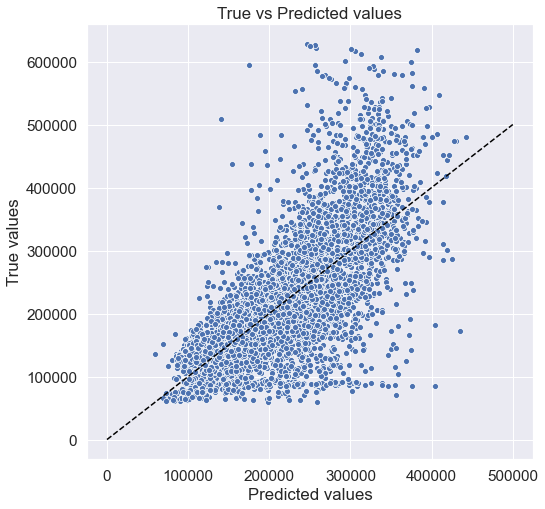

In [235]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.482
RMSE:	69075.566
MSE:	4771433785.71


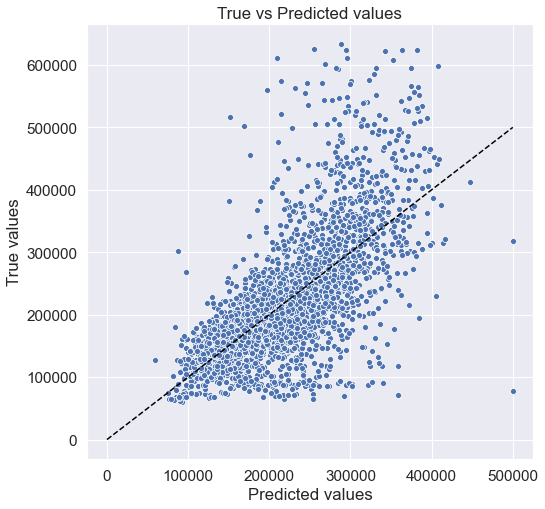

In [236]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

### Дерево решений

R2:	1.0
RMSE:	828.07
MSE:	685700.317


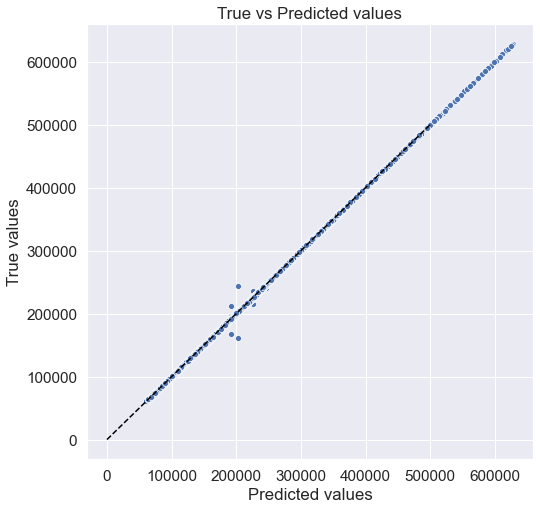

In [237]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.443
RMSE:	71605.44
MSE:	5127339098.217


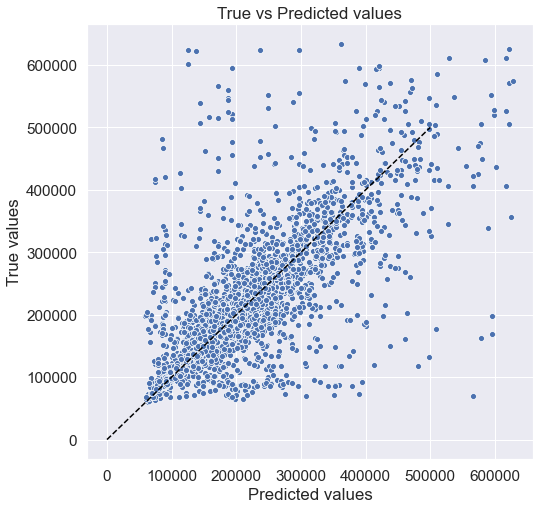

In [238]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Случайный лес

R2:	0.719
RMSE:	48420.665
MSE:	2344560755.674


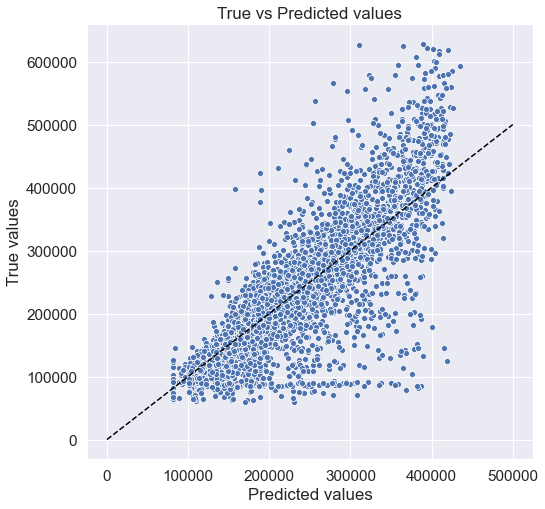

In [239]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.679
RMSE:	54351.106
MSE:	2954042685.084


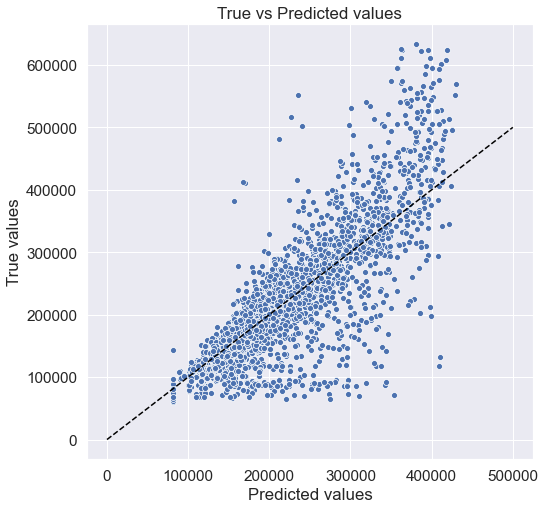

In [240]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Градиентный бустинг

R2:	0.901
RMSE:	28765.594
MSE:	827459395.882


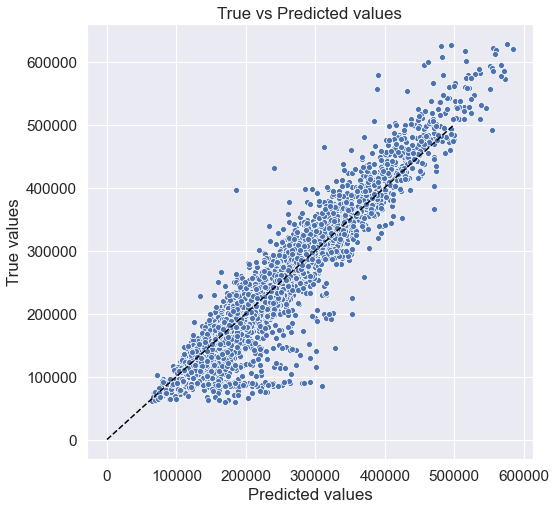

In [241]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.728
RMSE:	50065.466
MSE:	2506550921.084


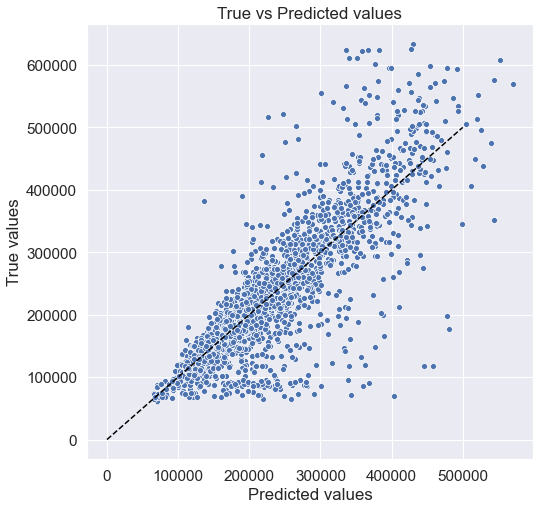

In [242]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [168]:
# Градиентный бустинг и случайный лес пока показывают лучшие значения R2

### Кроссвалидация

In [243]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 1min


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=7,
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [244]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.668734,0.010574,0.007779,0.000747,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.638693,0.627070,0.670961,0.684595,0.660533,0.656370,0.020966,16
1,1.304529,0.016871,0.008378,0.000489,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.671968,0.670218,0.711688,0.723268,0.705553,0.696539,0.021548,15


In [245]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [246]:
gs.best_score_

#лучшие параметры и предполагаемый результат известен. Попробуем применить это в финальной модели

0.7350562043695035

In [247]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=200)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          n_estimators=200, random_state=42)

R2:	0.882
RMSE:	31349.61
MSE:	982798052.953


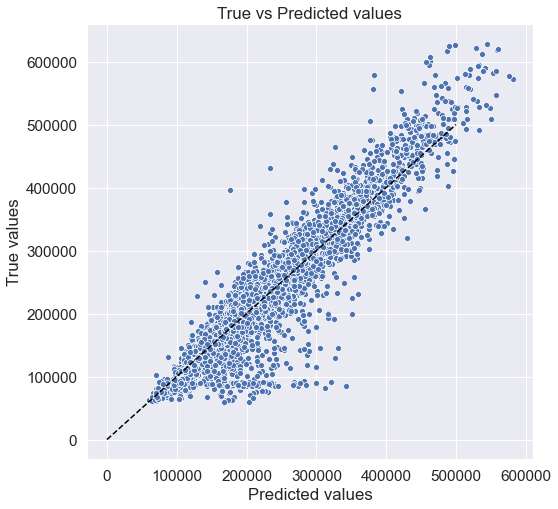

In [248]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.739
RMSE:	49051.743
MSE:	2406073497.571


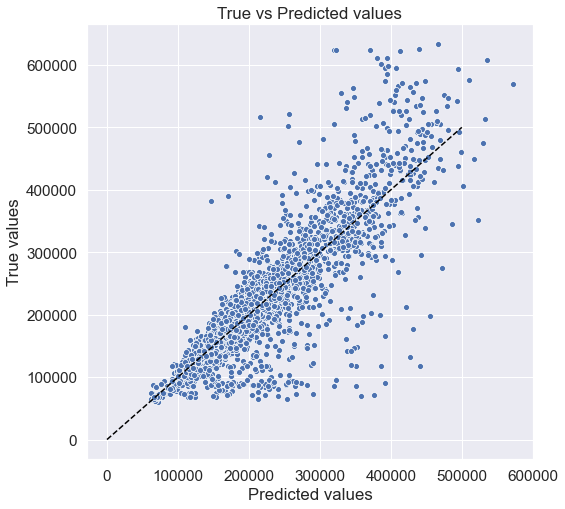

In [249]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Применение на тестовом файле

In [264]:
test = pd.read_csv(TEST_DATASET)
test = reduce_mem_usage(test)
test.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [265]:
# готовим данные
test = prepare_data(test)

In [266]:
# стандартизация данных
feature_names_for_stand = test[feature_names].select_dtypes(include=['int8', 'int16', 'int32', 'float32']).columns.tolist()

scaler = StandardScaler()
stand_features = scaler.fit_transform(test[feature_names_for_stand])

test[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,4567,-0.164781,-1.085258,-1.026766,-1.063629,-0.098180,-0.662450,-0.530453,1970.0,-0.697594,False,False,-0.053267,-0.255550,-0.346275,-0.215841,-0.678852,False
1,5925,0.242689,-1.085258,-0.731008,-0.173738,0.404381,-0.297665,0.648004,2017.0,-0.397445,False,False,-1.308227,-1.186699,-0.304366,-0.891612,-0.888194,True
2,960,-0.549613,0.107333,0.157886,-0.145103,0.303869,1.891046,0.942619,1977.0,0.762360,False,False,-0.908921,-0.873004,-0.346275,-0.891612,-0.678852,False
3,3848,-0.640162,1.299924,-0.356373,-0.080768,0.002332,-1.209628,-1.561604,1965.0,-0.881250,False,False,-1.308227,-1.224948,-0.346275,-0.891612,-0.888194,False
4,746,0.514336,-1.085258,-0.136843,-0.145103,-0.500230,-0.115272,0.648004,1977.0,1.579283,False,False,0.574212,0.573268,-0.178640,-0.891612,0.367855,False


In [267]:
# применение обученной модели
z = test[feature_names]
test_predict = final_model.predict(z)

In [269]:
# выгрузка в файл

pd.DataFrame({ 'Id': test['Id'], 'Price': test_predict }).to_csv(TEST_DATASET_EXT_PATH, index=False)